# Inverse Problem: recovering permeability filed from sparse, noisy observation

**Noise level:** $$SNR = 10\log_{10}\frac{\bar{u}}{\sigma^2}$$, where $\bar{u}=\frac{1}{n}\sum^{n}_{i=1}u^2_i$. Therefore, $$\sigma = \sqrt{\frac{\bar{u}}{10^{SNR/10}}}$$

## (1) Prepare data

a shape: torch.Size([1, 841, 1])
u shape: torch.Size([1, 841, 1])
u_noise shape: torch.Size([1, 841, 1])
x shape: torch.Size([1, 841, 2])
**********************************
The observed positions size: (100,)


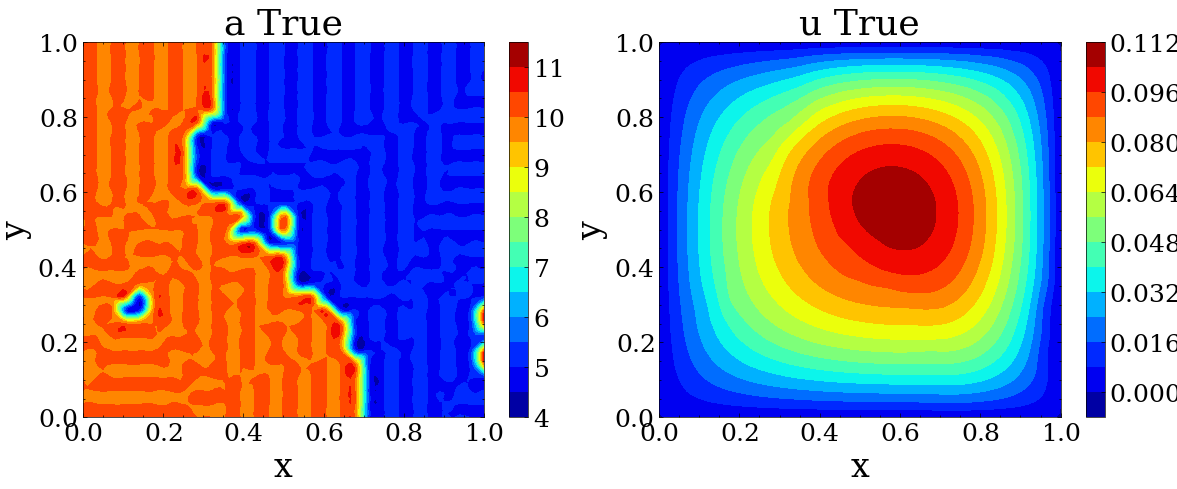

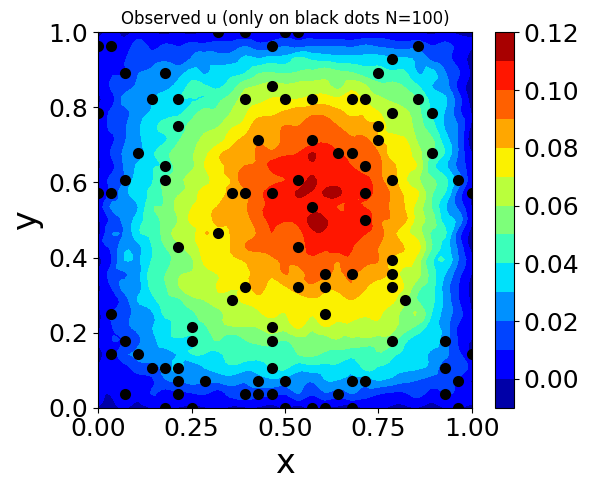

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
import random
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 1234
setup_seed(random_seed)
device = 'cpu'
dtype = torch.float32
noise_level = 'SNR25'
tag = 'data1000'

######################################
# Load training data
######################################
data = h5py.File('dataset/pwc_inverse_coe.mat', 'r')
######################################
from Utils.utils import *
def get_data(data, dtype):
    gridx = np2tensor(np.array(data["x"]), dtype)
    a = np2tensor(np.array(data["a"]), dtype)
    u = np2tensor(np.array(data["u"]), dtype)
    index_obs = np.array(data["index_obs"])
    ##########################
    sig_avg_watts = torch.mean(u**2)
    #
    if noise_level=='SNR20':
        scale = np.sqrt(sig_avg_watts/10**(20/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR25':
        scale = np.sqrt(sig_avg_watts/10**(25/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR50':
        scale = np.sqrt(sig_avg_watts/10**(50/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR100':
        scale = np.sqrt(sig_avg_watts/10**(100/10))
        u_noise = u + torch.randn_like(u) * scale
    
    return a.unsqueeze(0), u.unsqueeze(0), u_noise.unsqueeze(0), gridx, index_obs
#
a_true, u_true, u_noise, gridx, inx_obs = get_data(data, dtype)
x = gridx.unsqueeze(0)
print('a shape:', a_true.shape)
print('u shape:', u_true.shape)
print('u_noise shape:', u_noise.shape)
print('x shape:', x.shape)
print('**********************************')
print('The observed positions size:', inx_obs.shape)
########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx]*2, [a_true, u_true], ['a True', 'u True'], lb =0.)
#########################################
#The observations (sparse and noisy)
#########################################
from scipy.interpolate import griddata
plt.figure(figsize=(6,5))
mesh = np.meshgrid(np.linspace(0., 1., 100), np.linspace(0., 1., 100))
x_plot, y_plot = mesh[0], mesh[1]
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_noise), (x_plot, y_plot), method='cubic')
cntr = plt.contourf(x_plot, y_plot, z_plot, levels=14, cmap='jet')
plt.scatter(x[0,inx_obs,0], x[0,inx_obs,1], color='k', linewidth=2.)
plt.colorbar(cntr)
plt.title('Observed u (only on black dots N=100)', fontsize=12)
plt.xlabel('x')
plt.ylabel('y')
#
plt.tight_layout()
plt.show()

## (2) Define the loss class

### (2.1) load the trained forward model

In [2]:
######################################
# load the trained forward model
######################################
import torch.nn as nn
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_list, activation, dtype):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_list, activation, dtype) 
        
    def forward(self, feat):
        '''
        Input:
            feat: size(batch_size, a_size)
        Return:
            output: size(?, beta_size) -> size(? beta_size)
        '''
        beta = self.encoder(feat)
        beta = torch.tanh(beta)
        return beta
#
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent128_{tag}/', 
                                 name=f'model_dgno_final')

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class BetaModel(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(BetaModel, self).__init__()
        self.fc = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, ones):
        beta = self.fc(ones)
        beta = torch.tanh(beta)
        
        return beta
#
layers_beta, act_beta = [1, 64, 64, 128], 'SiLU'
model_beta = BetaModel(layers_beta, act_beta, dtype=dtype).to(device)

### (2.2) Define the loss class

In [3]:
###############################
# Define Loss Class
###############################
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
##### The test function
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
class mollifier(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        
        return u.unsqueeze(-1)
        
#################################
def a_sample(a_prob, samples=25):
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a
    
################################
class LossClass(object):

    def __init__(self, model_beta):
        super(LossClass, self).__init__()
        ''' '''
        self.device = solver.device
        self.mollifier = mollifier()
        self.model_u = model_trained['u']
        self.model_a = model_trained['a']
        self.model_s1 = model_trained['s1']
        self.model_s2 = model_trained['s2']
        self.model_beta = model_beta
        self.ones = torch.ones((1,1,1)).to(device)
        #######################
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)
        #
        self.inx_obs = inx_obs

    def Loss_pde(self, nc=100):
        beta = self.model_beta(self.ones)
        n_batch = 1
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1, 1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ################ model prediction ###########
        a_detach = nn.Sigmoid()(self.model_a(x.detach(), beta))
        a_detach = a_sample(a_detach).unsqueeze(-1)
        # u: size(n_batch, nc*n_grid, 1)
        u = self.model_u(x, beta)
        u = self.mollifier(u, x)
        # s: size(n_batch, nc*n_grid, 2)
        s = torch.stack([self.model_s1(x, beta), self.model_s2(x, beta)], dim=-1)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss #################### 
        res1 = torch.sum( (s - a_detach * du)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
        res1 = torch.mean(res1, dim=-1)
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum(s * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f*v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        res2 = (left-right)**2
        
        return torch.mean(res1) + torch.mean(res2) * np.sqrt(nc)
        
    def Loss_data(self, x, u):
        '''Note: observations are available on positions: 'inx_obs'
        '''
        x_obs = x[:,self.inx_obs,:]
        u_obs = u[:,self.inx_obs,:]
        #
        beta = self.model_beta(self.ones)
        u_pred = self.model_u(x_obs, beta)
        u_pred = self.mollifier(u_pred, x_obs)
        #
        loss_u = torch.norm(u_pred-u_obs, 2, 1) / torch.norm(u_obs, 2, 1)
        
        return torch.mean(loss_u) 

    def Error_a(self, x, a):
        beta = self.model_beta(self.ones)
        a_pred = nn.Sigmoid()(self.model_a(x.detach(), beta))
        a_pred = a_sample(a_pred)
        #
        err_a = torch.norm(a_pred-a.squeeze(-1), 2, 1) / torch.norm(a.squeeze(-1), 2, 1)

        return torch.mean(err_a)

    def Error_u(self, x, u):
        beta = self.model_beta(self.ones)
        u_pred = self.model_u(x, beta)
        u_pred = self.mollifier(u_pred, x)
        #
        err_u = torch.norm(u_pred-u, 2, 1) / torch.norm(u, 2, 1)

        return torch.mean(err_u)

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])


## (3) solve the optimization problem

In [4]:
import os
import time
from tqdm import trange

epochs = 500
lr = 1e-2
w_data, w_pde = 25., 1.
optimizer = torch.optim.Adam(params=model_beta.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/10), gamma=0.5)
loss_list, error_list = [], []
t0 = time.time()
for epoch in trange(epochs):
    lossClass = LossClass(model_beta)
    loss_pde = lossClass.Loss_pde()
    loss_data = lossClass.Loss_data(x, u_noise)
    loss_train = w_pde * loss_pde + w_data * loss_data
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    scheduler.step()  # Adjust learning rate
    #
    with torch.no_grad():
        error_a = lossClass.Error_a(x, a_true)
        error_u = lossClass.Error_u(x, u_true)
        error_list.append(error_a.item())
    #
    loss_list.append(loss_train.item())
    if (epoch+1)%50==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}')
        print('error_a:', error_a.item(), 'error_u:', error_u.item())
print('The consuming time is:', time.time()-t0)
############################################## save the trained model
def saveModel(path:str, model):
    '''Save trained model (the whole model)
    '''
    if not os.path.exists(path):
        os.makedirs(path)
    #
    torch.save(model, path+f'dgno_inverse_N100_{tag}.pth')
#
saveModel(f'saved_models/DGNO_inverse_{noise_level}/', model_beta)

 11%|████████▍                                                                       | 53/500 [00:03<00:29, 15.07it/s]

Epoch:49, The loss is:1.2365069389343262
error_a: 0.13476182520389557 error_u: 0.028552653267979622


 21%|████████████████▎                                                              | 103/500 [00:06<00:21, 18.31it/s]

Epoch:99, The loss is:1.2273558378219604
error_a: 0.13633504509925842 error_u: 0.029815882444381714


 31%|████████████████████████▏                                                      | 153/500 [00:09<00:19, 17.89it/s]

Epoch:149, The loss is:1.223555088043213
error_a: 0.13425295054912567 error_u: 0.02970595844089985


 41%|████████████████████████████████                                               | 203/500 [00:12<00:16, 18.11it/s]

Epoch:199, The loss is:1.2168803215026855
error_a: 0.13658276200294495 error_u: 0.029190728440880775


 51%|███████████████████████████████████████▉                                       | 253/500 [00:14<00:13, 18.14it/s]

Epoch:249, The loss is:1.2215399742126465
error_a: 0.13905133306980133 error_u: 0.028931234031915665


 61%|███████████████████████████████████████████████▊                               | 303/500 [00:17<00:10, 18.39it/s]

Epoch:299, The loss is:1.2126867771148682
error_a: 0.14053170382976532 error_u: 0.028957366943359375


 71%|███████████████████████████████████████████████████████▊                       | 353/500 [00:20<00:08, 18.19it/s]

Epoch:349, The loss is:1.2130305767059326
error_a: 0.13960540294647217 error_u: 0.02883920446038246


 81%|███████████████████████████████████████████████████████████████▋               | 403/500 [00:23<00:05, 17.89it/s]

Epoch:399, The loss is:1.2179516553878784
error_a: 0.1402815878391266 error_u: 0.028955677524209023


 91%|███████████████████████████████████████████████████████████████████████▌       | 453/500 [00:25<00:02, 17.64it/s]

Epoch:449, The loss is:1.2159488201141357
error_a: 0.13968978822231293 error_u: 0.028898634016513824


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.53it/s]

Epoch:499, The loss is:1.2215951681137085
error_a: 0.13886575400829315 error_u: 0.02890782617032528
The consuming time is: 28.529887676239014


## (4) Plot the recovered result

The test l2 error (u avg): tensor(0.0289)
The test l2 error (a avg): tensor(0.1390)
The cross-correlation is: tensor(0.7910)
The sum-square is: tensor(0.0196)


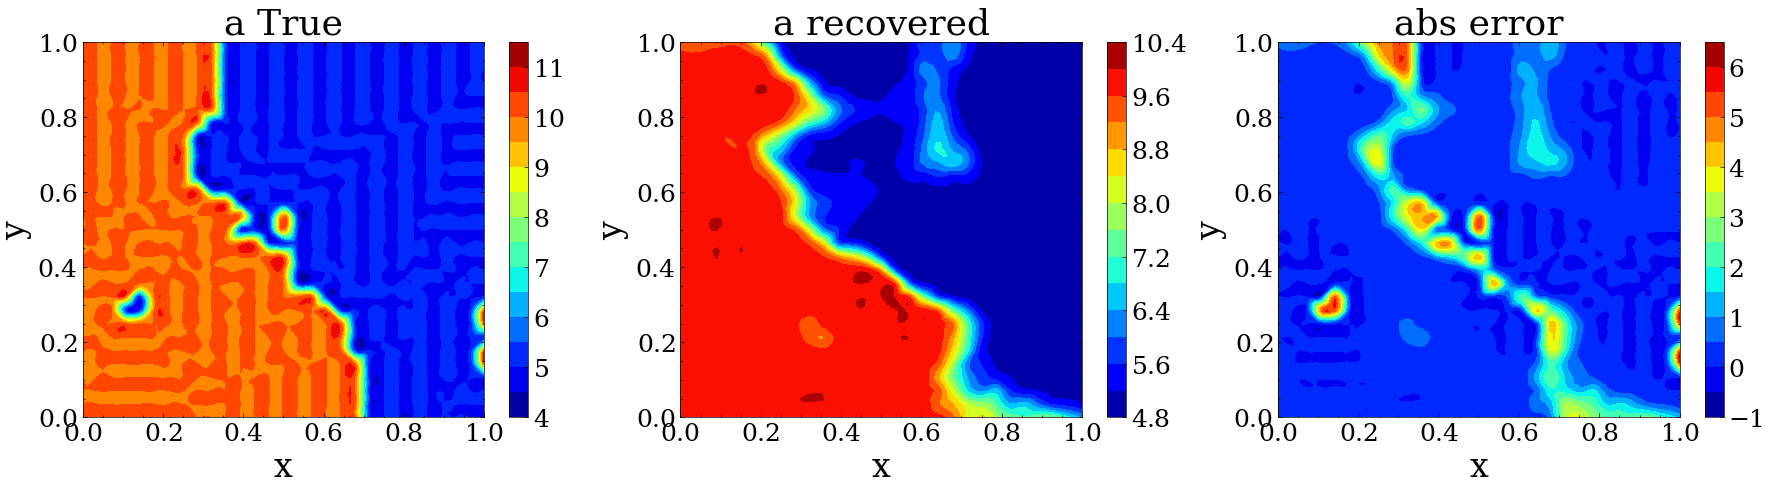

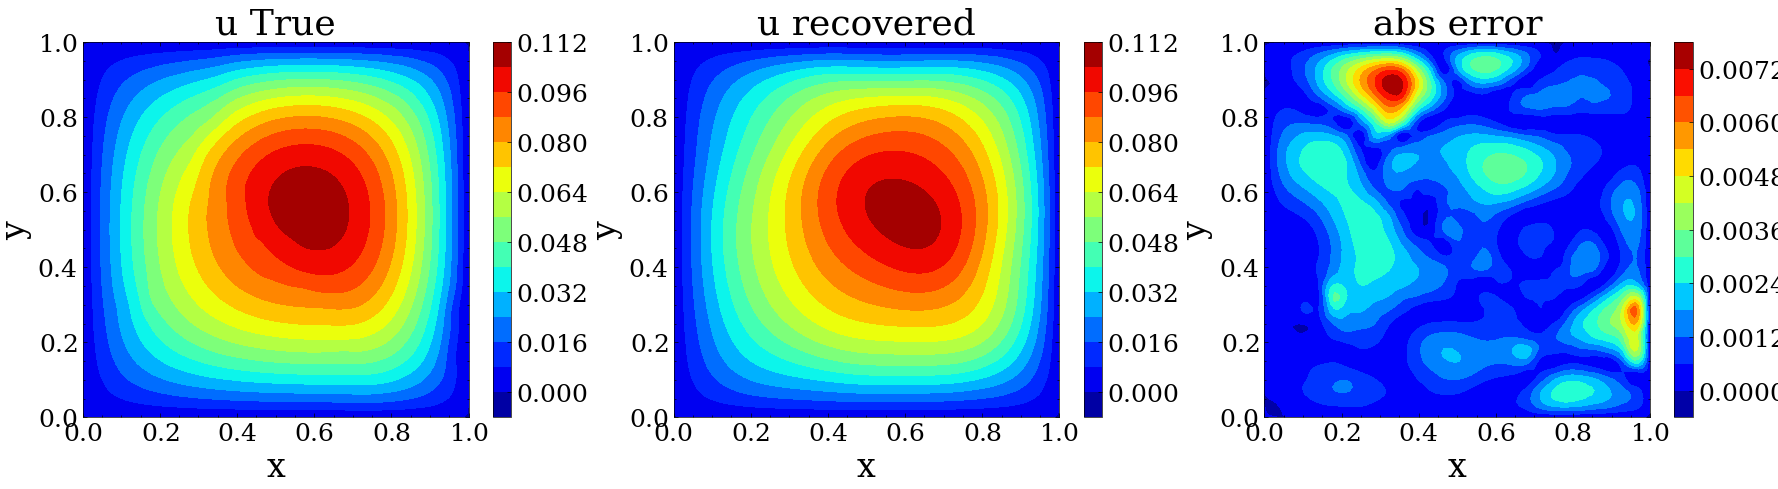

In [5]:
################################## make prediction
def a_sample(a_prob, samples=50):
    '''
    a_prob: size(n_batch, mesh_size, 1)
    '''
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a
#
with torch.no_grad():
    x_a = gridx.repeat(x.shape[0], 1, 1).to(device)
    x_var = x.to(device)
    beta_pred = model_beta(torch.ones((1,1,1)).to(device))
    #
    u_pred = model_trained['u'](x_var, beta_pred)
    u_pred = mollifier()(u_pred, x_var).detach().cpu()
    #
    a_pred = nn.Sigmoid()(model_trained['a'](x_a, beta_pred))
    a_pred = a_sample(a_pred).detach().cpu().unsqueeze(-1)
#
print('The test l2 error (u avg):', solver.getError(u_pred, u_true))
print('The test l2 error (a avg):', solver.getError(a_pred, a_true))

############################################
def metrics(a_pred, a_test):
    ''' '''
    a_pred_scale = a_pred/10.
    a_test_scale = a_test/10.
    #
    norm_pred = torch.sum(a_pred_scale**2)
    norm_test = torch.sum(a_test_scale**2)
    ################ Cross-Correlation
    dist_cc = torch.sum( (a_pred_scale*a_test_scale)**2 )
    dist_cc = dist_cc/torch.sqrt(norm_pred*norm_test)
    print('The cross-correlation is:', dist_cc)
    ################# Sum Square Difference
    dist_ss = torch.sum( (a_pred_scale-a_test_scale)**2 )
    dist_ss = dist_ss/torch.sqrt(norm_pred*norm_test)
    print('The sum-square is:', dist_ss)
    return 
metrics(a_pred, a_true)

# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx, [a_true, a_pred, abs(a_pred-a_true)], 
                  ['a True', 'a recovered', 'abs error'], lb=0.)
Plot.show_2d_list(gridx, [u_true, u_pred, abs(u_pred-u_true)],
                  ['u True', 'u recovered', 'abs error'], lb=0.)